In [ ]:
'''
----------------------------------------------
Generating Epsilon-Delta curves

last updated: 06/10/2022
----------------------------------------------
The method used here are: 
FFT-Fei, FFT-Gopi, Saddlepoint Accountant, 
Moments Accountant.
----------------------------------------------
'''

KL= 0.006386136344532448
0.0


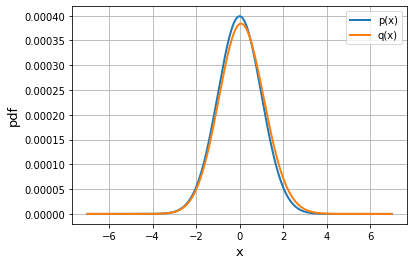

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Egamma_bounds import pq_upper
# from Egamma_bounds import pq_lower

# We first set parameters

composition = 500
sen = 1
subsampling = 0.1
C=1
c_type='l2'
noise_type='gaussian'

if noise_type == "cactus":
    filename = ('TestData/cactusM_s%.1f_%s_c%.2f_x.csv' %(sen,c_type,C))
    x = np.genfromtxt(filename, dtype=np.float32)
    x_grid = x.reshape(-1)
    
    filename = ('TestData/cactusM_s%.1f_%s_c%.2f_p.csv' %(sen,c_type,C))
    p = np.genfromtxt(filename, dtype=np.float32)
    p = p.reshape(len(p),1)
    
    n=int(1/(x[1]-x[0]))
    x_max=max(x_grid)
    po = p[0:-sen*n-1]
    print(np.shape(po))
    qo = subsampling*p[sen*n+1:]+(1-subsampling)*po
    print(np.shape(qo))

else:
    
    if noise_type=="gaussian":
        sigma=np.sqrt(C)
        f = lambda x: 1/np.sqrt(2*np.pi)/sigma*np.exp(-x**2/2/sigma**2)

    if noise_type == "laplace":
        b = np.sqrt(C/2)
        f = lambda x:1/2/b*np.exp(-np.abs(x)/b)
    
    x_max = sigma*7
    x_step_size=1e-3
    n = int(1/x_step_size)
    x_grid = np.arange(-x_max, x_max,x_step_size)
    po = np.array([f(X) for X in x_grid])*x_step_size
    qo = subsampling*np.array([f(X) for X in x_grid-sen])*x_step_size+(1-subsampling)*po
    
KL = np.sum(po*np.log(po/qo))
print("KL=",KL)

plt.figure

plt.plot(x_grid, po,label = ("p(x)"),linewidth=2)
plt.plot(x_grid, qo,label = ("q(x)"),linewidth=2)

plt.xlabel(r"x",fontsize=13)
plt.ylabel(r"pdf",fontsize=13)
plt.legend(loc='best')
plt.grid()

Eg = lambda gamma: np.sum(np.maximum(0,po-gamma*qo))

print(Eg(6))

# Next, we sample the Egamma curve uniformly
if noise_type == "gaussian":
    if subsampling !=1:
        rate = po/qo
        gamma_max = np.max(rate)
        gamma_min = np.min(rate)
    else:
        gamma_max = np.min(10,np.exp(composition*KL*3))
else:
    rate = po/qo
    gamma_max = np.max(rate)
    gamma_min = np.min(rate)

l_step_size = 1e-3
l_grid = np.arange(np.log(gamma_min),np.log(gamma_max),l_step_size)



In [4]:
'''
----------------------------------------------
FFT-Fei:
----------------------------------------------
Step 1: Obtain a E-gamma curve on gamma_grid via function Eg(gamma_grid) -> Eg_grid

Step 2(a): Obtain distribution pair upper bounding Eg_grid -> (p2,q2)
      (b): Use (eps_grid,p2) as a random variable L_low 
      (c): Perform FFT and iFFT to get convoluted (l_grid_padding,fLConvFFT_array2)
      (d): Compute the Egamma_upper()

Step 3(a): Obtain distribution pair lower bounding Eg_grid -> (p3,q3)
      (b): Use (eps_grid,p3) as a random variable L_low 
      (c): Perform FFT and iFFT to get convoluted (l_grid_padding,fLConvFFT_array3)
      (d): Compute the Egamma_lower()
----------------------------------------------
'''

gamma_grid = np.exp(l_grid)

# Again, we use Egamma2 for verifing the result, it should be an upper bound of the true Egamma curve.
p2,q2 = pq_upper(Eg,gamma_grid);

# Lastly, we get a lower bounding discrete model (p3,q3).
Egslope = lambda gamma: -sum([qo[i] if po[i]>gamma*qo[i] else 0 for i in range(0,len(po))])


from scipy.optimize import fsolve
from scipy.spatial import ConvexHull
def pq_lower(Eg,Egslope,gamma_grid):
    
    f_grid = np.zeros(np.shape(gamma_grid))
    f_grid[0] = Eg(gamma_grid[0])
    f_grid[-1] = 0
    
    for i in range(1,len(f_grid)-2):
        myfunc = lambda gamma: (Eg(gamma)-f_grid[i-1])/(gamma-gamma_grid[i-1])-Egslope(gamma)
        tmin = gamma_grid[i-1]+np.spacing(gamma_grid[i-1])
        tmax = gamma_grid[i]
        if i%100==0:
            print(i)
        
        if myfunc(tmax) >= 0:
            f_grid[i]=Eg(tmax)
        else:
            if myfunc(tmin)<=0:
                slp=Egslope(gamma_grid[i-1])
            else:          
                t = fsolve(myfunc,tmin,xtol=1e-3)
                slp = (Eg(t)-f_grid[i-1])/(t-gamma_grid[i-1])
            f_grid[i] = max(0,f_grid[i-1]+slp*(gamma_grid[i]-gamma_grid[i-1]))
    gamma_grid_ext = np.concatenate(([0],gamma_grid))
    print(np.shape(gamma_grid_ext))
    f_grid_ext = np.concatenate(([1],f_grid))
    print(np.shape(f_grid_ext))
    hull = ConvexHull(np.stack((gamma_grid_ext,f_grid_ext)))
    K=hull.simplices
    print("K",K)
    slope = np.array([f_grid_ext[i] for i in K[1:-1]]-[f_grid_ext[i] for i in K[0:-2]])/np.array([gamma_grid_ext[i] for i in K[1:-1]]-[gamma_grid_ext[i] for i in K[0:-2]])
    q = np.zeros(np.shape(gamma_grid))
    for j in range(1,len(K)-2):
        q[K[j]] = slope[j]-slope[j-1]
    q[-1]=-slope[-2]
    p = q*gamma_grid
    return p,q


p3,q3 = pq_lower(Eg,Egslope,gamma_grid);
plt.figure
plt.plot(p3)
plt.plot(q3)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
(4317,)
(4317,)


TypeError: only integer scalar arrays can be converted to a scalar index

[[0.40266578 0.11800789]
 [0.42809009 0.39256351]
 [0.37759341 0.55094771]
 [0.47031484 0.33880052]
 [0.19084451 0.57649803]
 [0.315568   0.95334574]
 [0.59541886 0.79321276]
 [0.67825974 0.29384231]
 [0.26860614 0.31347901]
 [0.25206399 0.64757269]]
[[5 4]
 [0 7]
 [6 7]
 [6 5]
 [8 4]
 [8 0]]


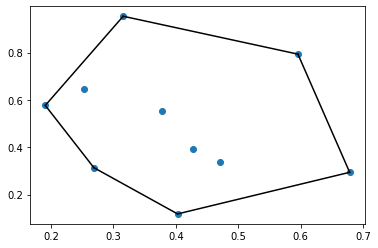

In [25]:
import numpy as np
rng = np.random.default_rng()
a = rng.random((10))
b = rng.random((10))
print((np.stack((a,b),axis=1)))
hull=ConvexHull(np.stack((a,b),axis=1))
print(hull.simplices)

import matplotlib.pyplot as plt
plt.plot(a[:], b[:], 'o')
for simplex in hull.simplices:
    plt.plot(a[simplex], b[simplex], 'k-')
